In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

### 集成基本思想：

训练时用多种分类器一起完成同一份任务
![title](./img/1.png)

测试时对待测试样本分别通过不同的分类器，汇总最后的结果
![title](./img/2.png)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

D:\Programing\Anaconda3\envs\sklearn_env\lib\site-packages\sklearn\feature_extraction\text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict


In [3]:
print(X.shape, y.shape)

(500, 2) (500,)


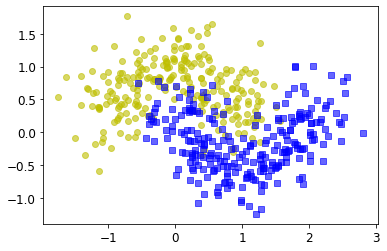

In [4]:
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'yo', alpha=0.6)
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs', alpha=0.6)

### 投票策略：软投票与硬投票
- 硬投票：直接用类别值，少数服从多数
- 软投票：各自分类器的概率值进行加权平均

#### 硬投票实验

In [5]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(estimators=[('log', log_clf), ('rf', rnd_clf),
                                          ('svc', svm_clf)],
                              voting='hard')

D:\Programing\Anaconda3\envs\sklearn_env\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('log', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFo...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [7]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


D:\Programing\Anaconda3\envs\sklearn_env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### 软投票实验

In [8]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

loglog_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)  # 软投票：要求必须各个分别器都能得出概率值

voting_clf = VotingClassifier(estimators=[('log', log_clf), ('rf', rnd_clf),
                                          ('svc', svm_clf)],
                              voting='soft')

In [9]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('log', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFo...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [10]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


D:\Programing\Anaconda3\envs\sklearn_env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Bagging策略
- 首先对训练数据集进行多次采样，保证每次得到的采样数据都是不同的
- 分别训练多个模型，例如树模型
- 预测时需得到所有模型结果再进行集成

![title](./img/3.png)

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,  # 每个基本模型使用的样本
    bootstrap=True,  # 有放回抽样
    n_jobs=-1,  # 并行使用所有CPU
    random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [12]:
y_pred

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

In [13]:
accuracy_score(y_test, y_pred)

0.904

In [14]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

In [15]:
y_pred_tree

array([1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

In [16]:
accuracy_score(y_test, y_pred_tree)

0.856

### 决策边界
- 集成与传统方法对比

In [17]:
from matplotlib.colors import ListedColormap


def plot_decision_boundary(clf,
                           X,
                           y,
                           axes=[-2, 3, -2, 2],
                           alpha=0.6,
                           contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    coustom_comp = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, cmap=coustom_comp, alpha=0.3)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=coustom_comp, alpha=1)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 1], 'yo', alpha=0.6)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs', alpha=0.6)
    plt.axis(axes)
    plt.xlabel('x1')
    plt.ylabel('x2')

Text(0.5, 1.0, 'Decision Tree with Bagging')

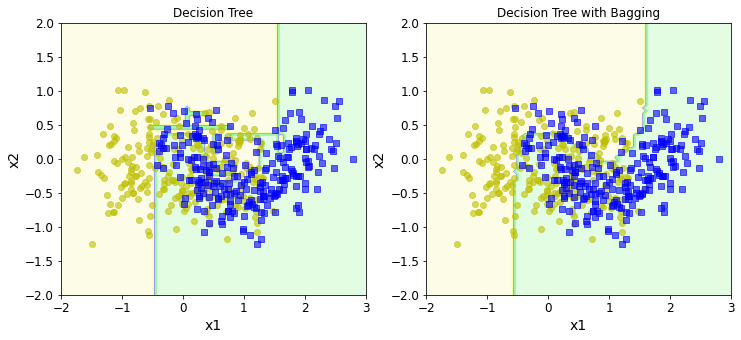

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title('Decision Tree')
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title('Decision Tree with Bagging')

Text(0.5, 1.0, 'Decision Tree with Bagging')

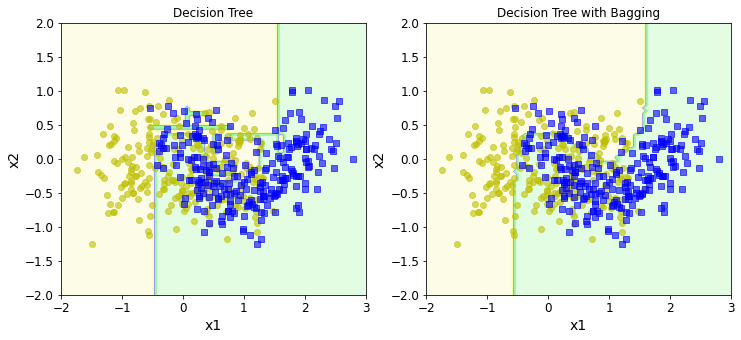

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y, contour=True)
plt.title('Decision Tree')
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y, contour=True)
plt.title('Decision Tree with Bagging')

Colormap颜色：https://blog.csdn.net/zhaogeng111/article/details/78419015

### OOB策略
- Out Of Bag

In [20]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,  # 每个基本模型使用的样本
    bootstrap=True,  # 有放回抽样
    n_jobs=-1,  # 并行使用所有CPU
    random_state=42,
    oob_score=True)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=True,
         random_state=42, verbose=0, warm_start=False)

In [21]:
bag_clf.oob_score_

0.9253333333333333

In [22]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

In [23]:
bag_clf.oob_decision_function_

array([[0.35849057, 0.64150943],
       [0.43513514, 0.56486486],
       [1.        , 0.        ],
       [0.0128866 , 0.9871134 ],
       [0.03174603, 0.96825397],
       [0.07928389, 0.92071611],
       [0.4027027 , 0.5972973 ],
       [0.06703911, 0.93296089],
       [0.92950392, 0.07049608],
       [0.88461538, 0.11538462],
       [0.59351621, 0.40648379],
       [0.04896907, 0.95103093],
       [0.7591623 , 0.2408377 ],
       [0.82908163, 0.17091837],
       [0.88279302, 0.11720698],
       [0.07407407, 0.92592593],
       [0.04488778, 0.95511222],
       [0.92307692, 0.07692308],
       [0.70737913, 0.29262087],
       [0.94358974, 0.05641026],
       [0.06366048, 0.93633952],
       [0.22933333, 0.77066667],
       [0.91002571, 0.08997429],
       [0.98746867, 0.01253133],
       [0.96236559, 0.03763441],
       [0.        , 1.        ],
       [0.94255875, 0.05744125],
       [1.        , 0.        ],
       [0.02933333, 0.97066667],
       [0.70454545, 0.29545455],
       [0.

In [24]:
bag_clf.oob_decision_function_.shape

(375, 2)

### 随机森林

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### 特征重要性：
sklearn中是看每个特征的平均深度

In [26]:
from sklearn.datasets import load_iris

iris = load_iris()
rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'],
                       rf_clf.feature_importances_):  # 重要性不排序
    print(name, score)

sepal length (cm) 0.11105536416721994
sepal width (cm) 0.02319505364393038
petal length (cm) 0.44036215067701534
petal width (cm) 0.42538743151183406


In [27]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
# 如果无法导入，是版本问题，将scikit-learn版本降为0.19就可以了。

In [28]:
rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
rf_clf.feature_importances_.shape

(784,)

In [30]:
rf_clf.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.58007640e-07, 3.47901903e-07, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.87057492e-07, 1.09519368e-06,
       1.34760378e-06, 1.48017002e-06, 2.53430072e-06, 4.89983187e-06,
       4.01401741e-06, 3.29376875e-06, 3.40258584e-06, 3.68469303e-06,
       3.24532331e-06, 2.37478593e-06, 1.26936385e-06, 9.23620960e-07,
       1.32859895e-06, 6.33046851e-07, 4.75454102e-07, 3.76885375e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [31]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.hot)
    plt.axis('off')

[Text(1, 0, 'Not important'), Text(1, 0, 'Very important')]

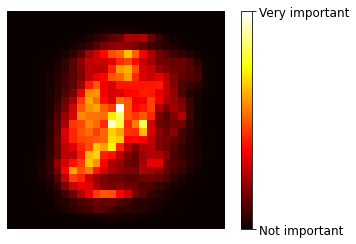

In [32]:
plot_digit(rf_clf.feature_importances_)
char = plt.colorbar(ticks=[
    rf_clf.feature_importances_.min(),
    rf_clf.feature_importances_.max()
])
char.ax.set_yticklabels(['Not important', 'Very important'])

### Boosting-提升策略
AdaBoost
跟上学时的考试一样，这次做错的题，是不是得额外注意，下次的时候就和别错了！

![title](./img/4.png)

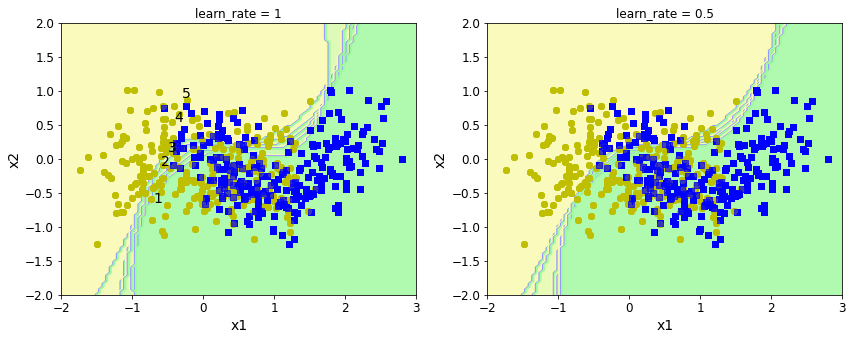

In [33]:
_  # 以SVM分类器为例来演示AdaBoost的基本策略
from sklearn.svm import SVC

m = len(X_train)

plt.figure(figsize=(14, 5))
for subplot, learning_rate in [(121, 1), (122, 0.5)]:
    sample_weight = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel='rbf', C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weight)
        y_pred = svm_clf.predict(X_test)
        sample_weight[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title('learn_rate = {}'.format(learning_rate))
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5, 0.10, "3", fontsize=14)
        plt.text(-0.4, 0.55, "4", fontsize=14)
        plt.text(-0.3, 0.90, "5", fontsize=14)

plt.show()

In [34]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                             n_estimators=200,
                             learning_rate=0.6,
                             random_state=42)

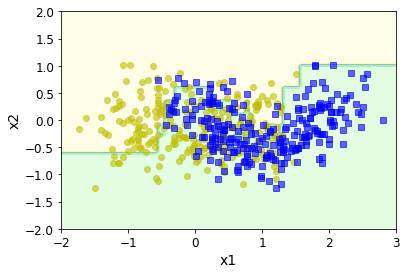

In [35]:
ada_clf.fit(X_train, y_train)
plot_decision_boundary(ada_clf, X, y)

### Gradient Boosting

In [36]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0]**2 + 0.05 * np.random.randn(100)

In [37]:
y.shape

(100,)

In [38]:
X.shape

(100, 1)

In [39]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [40]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [41]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [42]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [43]:
y_pred

array([0.75026781])

In [44]:
def plot_predictions(regressors,
                     X,
                     y,
                     axes,
                     label=None,
                     style='r-',
                     data_style='b.',
                     data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(
        regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc='upper center', fontsize=16)
    plt.axis(axes)

Text(0, 0.5, '$y$')

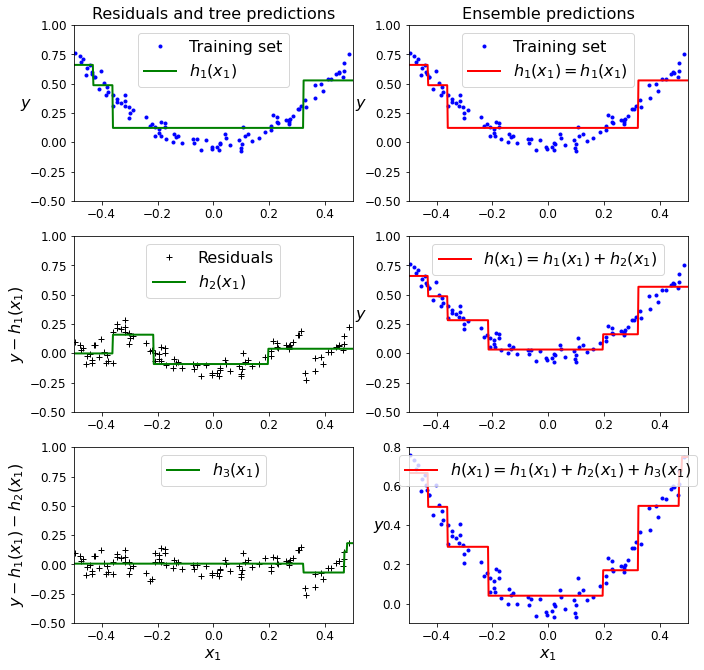

In [45]:
plt.figure(figsize=(11, 11))

plt.subplot(321)
plot_predictions([tree_reg1],
                 X,
                 y,
                 axes=[-0.5, 0.5, -0.5, 1],
                 label='$h_1(x_1)$',
                 style='g-',
                 data_label='Training set')
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title('Residuals and tree predictions', fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1],
                 X,
                 y,
                 axes=[-0.5, 0.5, -0.5, 1],
                 label='$h_1(x_1) = h_1(x_1)$',
                 data_label='Training set')
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title('Ensemble predictions', fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2],
                 X,
                 y2,
                 axes=[-0.5, 0.5, -0.5, 1],
                 label="$h_2(x_1)$",
                 style="g-",
                 data_style="k+",
                 data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2],
                 X,
                 y,
                 axes=[-0.5, 0.5, -0.5, 1],
                 label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3],
                 X,
                 y3,
                 axes=[-0.5, 0.5, -0.5, 1],
                 label="$h_3(x_1)$",
                 style="g-",
                 data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3],
                 X,
                 y,
                 axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=3,
                                 learning_rate=1.0,
                                 random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [47]:
gbrt_slow_1 = GradientBoostingRegressor(max_depth=2,
                                        n_estimators=3,
                                        learning_rate=0.1,
                                        random_state=42)
gbrt_slow_1.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [48]:
gbrt_slow_2 = GradientBoostingRegressor(max_depth=2,
                                        n_estimators=200,
                                        learning_rate=0.1,
                                        random_state=42)
gbrt_slow_2.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

Text(0.5, 1.0, 'learning_rate = 0.1, n_estimators = 3')

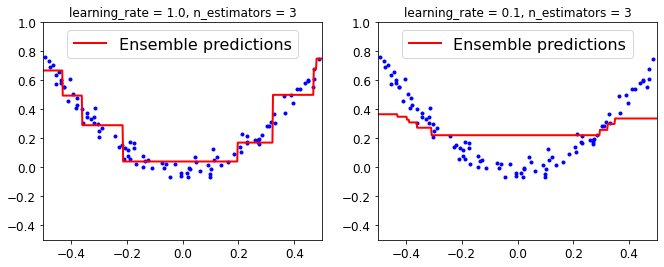

In [49]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions([gbrt],
                 X,
                 y,
                 axes=[-0.5, 0.5, -0.5, 1],
                 label='Ensemble predictions')
plt.title('learning_rate = {}, n_estimators = {}'.format(
    gbrt.learning_rate, gbrt.n_estimators))

plt.subplot(122)
plot_predictions([gbrt_slow_1],
                 X,
                 y,
                 axes=[-0.5, 0.5, -0.5, 1],
                 label='Ensemble predictions')
plt.title('learning_rate = {}, n_estimators = {}'.format(
    gbrt_slow_1.learning_rate, gbrt_slow_1.n_estimators))

Text(0.5, 1.0, 'learning_rate=0.1,n_estimators=3')

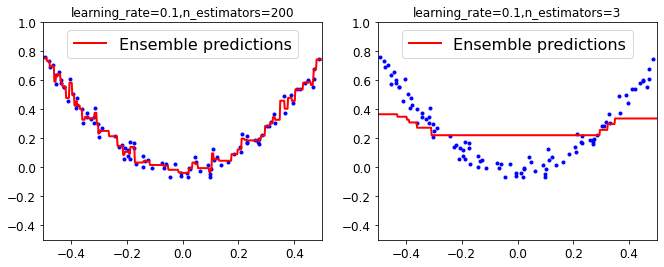

In [50]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions([gbrt_slow_2],
                 X,
                 y,
                 axes=[-0.5, 0.5, -0.5, 1],
                 label='Ensemble predictions')
plt.title('learning_rate={},n_estimators={}'.format(gbrt_slow_2.learning_rate,
                                                    gbrt_slow_2.n_estimators))

plt.subplot(122)
plot_predictions([gbrt_slow_1],
                 X,
                 y,
                 axes=[-0.5, 0.5, -0.5, 1],
                 label='Ensemble predictions')
plt.title('learning_rate={},n_estimators={}'.format(gbrt_slow_1.learning_rate,
                                                    gbrt_slow_1.n_estimators))

### 提前停止策略

In [51]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=150, random_state=42)
gbrt.fit(X_train, y_train)

errors = [
    mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)
]

In [52]:
errors

[0.05610899559053935,
 0.047560923813483064,
 0.04124088566823302,
 0.03517911550570251,
 0.030576406839652973,
 0.026637609691987457,
 0.023613435122730796,
 0.020369427024608137,
 0.018277048359280665,
 0.016091796347069243,
 0.014585571409641585,
 0.01314784747126986,
 0.01184057668005128,
 0.010756151385176995,
 0.009974274034504127,
 0.009207844894461165,
 0.008602269553103259,
 0.007962641266526736,
 0.007506170396302726,
 0.007068179441633813,
 0.006572858688497687,
 0.006346322118440629,
 0.005968251361221339,
 0.005585237785665257,
 0.005269348108968781,
 0.0051132977566933,
 0.004918143210452805,
 0.004717250988082721,
 0.004586540299323291,
 0.004476259729372586,
 0.004325970755074008,
 0.004180526256803691,
 0.0041368823736516605,
 0.004074456898994263,
 0.003990583924138555,
 0.0038974999584088436,
 0.003814385846946538,
 0.0037134828209850574,
 0.0036747256319290484,
 0.0036377893287685686,
 0.0035722601062841775,
 0.003539916282594281,
 0.0035273286851342117,
 0.00347526

In [53]:
bst_n_estimators = np.argmin(errors) + 1
bst_n_estimators  # 第117个索引为最小值，

118

In [54]:
gbrt_best = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=bst_n_estimators,
                                      random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=118, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [55]:
min_error = np.min(errors)
min_error

0.003009529324545136

Text(0.5, 1.0, 'Best Model (118 trees)')

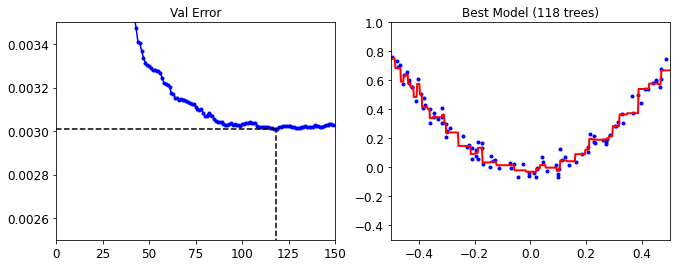

In [56]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, 'b.-')
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], 'k--')
plt.plot([0, 120], [min_error, min_error], 'k--')
plt.axis([0, 150, 0.0025, 0.0035])
plt.title('Val Error')

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.5, 1])
plt.title('Best Model (%d trees)' % bst_n_estimators)

In [57]:
# 提前停止策略
gbrt = GradientBoostingRegressor(max_depth=2, random_state=42,
                                 warm_start=True)  # 缓存之前树的计算结果
error_goingup = 0
min_val_error = float('inf')

for n_estimator in range(1, 151):
    gbrt.n_esttimators = n_estimator
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_goingup = 0
    else:
        error_goingup += 1
        if error_goingup == 5:
            break

In [58]:
print(gbrt.n_estimators)  # 连续5次错误提升才退出，但不代表最低错误值

100


### Stacking（堆叠集成）

![title](./img/5.png)

![title](./img/6.png)

In [59]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

mnist = fetch_mldata('MNIST original')

X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data,
                                                            mnist.target,
                                                            test_size=10000,
                                                            random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=10000,
                                                  random_state=42)

In [60]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

rf_clf = RandomForestClassifier(random_state=42)
et_clf = ExtraTreesClassifier(random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

estimators = [rf_clf, et_clf, svm_clf, mlp_clf]

In [61]:
for estimator in estimators:
    print('Training the', estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Training the ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
Training the LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr',

In [62]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)
for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

X_val_predictions

array([[2., 2., 2., 2.],
       [7., 7., 7., 7.],
       [4., 4., 4., 4.],
       ...,
       [4., 4., 4., 4.],
       [9., 9., 9., 9.],
       [4., 4., 4., 4.]], dtype=float32)

In [63]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200,
                                            oob_score=True,
                                            random_state=42,
                                            n_jobs=-1)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [64]:
rnd_forest_blender.oob_score_

0.9614